In [3]:
import pandas as pd

# Load all four datasets (update paths as needed)
df_main = pd.read_csv("Train-1542865627584.csv")
df_beneficiary = pd.read_csv("Train_Beneficiarydata-1542865627584.csv")
df_inpatient = pd.read_csv("Train_Inpatientdata-1542865627584.csv")
df_outpatient = pd.read_csv("Train_Outpatientdata-1542865627584.csv")

# Tag claim type
df_inpatient["ClaimType"] = "Inpatient"
df_outpatient["ClaimType"] = "Outpatient"

# Combine inpatient and outpatient datasets
df_claims = pd.concat([df_inpatient, df_outpatient], ignore_index=True)

# Merge with beneficiary data on BeneID
df_claims_merged = df_claims.merge(df_beneficiary, on="BeneID", how="left")

# Merge with fraud labels on Provider
df_claims_merged = df_claims_merged.merge(df_main, on="Provider", how="left")

# Save to CSV (optional)
#df_claims_merged.to_csv("Merged_Claims_HealthInsurance.csv", index=False)

# View the merged dataset
print("Shape of merged dataset:", df_claims_merged.shape)
df_claims_merged.head()

Shape of merged dataset: (558211, 56)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,1,1,2,1,1,36000,3204,60,70,Yes
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,1,1,2,1,1,36000,3204,60,70,No
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,1,1,2,1,1,36000,3204,60,70,No
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,1,2,2,1,1,5000,1068,250,320,No
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,...,2,1,2,2,2,21260,2136,120,100,No


In [5]:
# Save to CSV
df_claims_merged.to_csv("Merged_Claims_HealthInsurance.csv", index=False)

In [7]:
import pandas as pd

# Load your merged dataset with improved settings
df = pd.read_csv("Merged_Claims_HealthInsurance.csv", low_memory=False)

# Convert date columns to datetime
date_cols = ["DOB", "ClaimStartDt", "ClaimEndDt", "AdmissionDt", "DischargeDt"]
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce', dayfirst=True)

# Create new features
df["Age"] = (df["ClaimStartDt"] - df["DOB"]).dt.days // 365
df["ClaimDuration"] = (df["ClaimEndDt"] - df["ClaimStartDt"]).dt.days
df["HospitalStayLength"] = (df["DischargeDt"] - df["AdmissionDt"]).dt.days

print("✅ Dates parsed and new features created successfully.")
df[["DOB", "ClaimStartDt", "Age", "ClaimDuration", "HospitalStayLength"]].head()

✅ Dates parsed and new features created successfully.


/var/folders/t_/nb5xvbtd4_x7s9b64hbb25sr0000gn/T/ipykernel_33905/3573672630.py:10: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df[col] = pd.to_datetime(df[col], errors='coerce', dayfirst=True)
/var/folders/t_/nb5xvbtd4_x7s9b64hbb25sr0000gn/T/ipykernel_33905/3573672630.py:10: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df[col] = pd.to_datetime(df[col], errors='coerce', dayfirst=True)


,DOB,ClaimStartDt,Age,ClaimDuration,HospitalStayLength
0,1943-01-01,2009-12-04,66.0,-230.0,-230.0
1,1943-01-01,NaT,NaN,NaN,NaN
2,1943-01-01,NaT,NaN,NaN,NaN
3,1914-01-03,NaT,NaN,NaN,NaN
4,1938-01-04,NaT,NaN,NaN,NaN


In [9]:
# Fill missing diagnosis and procedure codes
diag_proc_cols = [col for col in df.columns if "ClmDiagnosisCode" in col or "ClmProcedureCode" in col]
df[diag_proc_cols] = df[diag_proc_cols].fillna("Missing")

# Encode categorical variables
df["Gender"] = df["Gender"].map({1: "Male", 2: "Female"})
df["RenalDiseaseIndicator"] = df["RenalDiseaseIndicator"].map({"Y": 1, "0": 0})

# Save to CSV
df.to_csv("Cleaned_Claims_HealthInsurance.csv", index=False)
print("Cleaning complete. File saved as Cleaned_Claims_HealthInsurance.csv")

Cleaning complete. File saved as Cleaned_Claims_HealthInsurance.csv


In [11]:
# Group by Provider and create aggregates
provider_agg = df.groupby("Provider").agg(
    TotalClaimAmount=("InscClaimAmtReimbursed", "sum"),
    AvgClaimAmount=("InscClaimAmtReimbursed", "mean"),
    TotalDeductible=("DeductibleAmtPaid", "sum"),
    AvgDeductible=("DeductibleAmtPaid", "mean"),
    NumClaims=("ClaimID", "count"),
    AvgClaimDuration=("ClaimDuration", "mean"),
    AvgHospitalStay=("HospitalStayLength", "mean"),
    AvgAge=("Age", "mean")
).reset_index()

# Merge with the fraud label
provider_agg = provider_agg.merge(df[["Provider", "PotentialFraud"]].drop_duplicates(), on="Provider", how="left")

# Save for model training
provider_agg.to_csv("Provider_FeatureSet.csv", index=False)

print("Provider-level feature engineering complete. File saved as Provider_FeatureSet.csv")

Provider-level feature engineering complete. File saved as Provider_FeatureSet.csv


In [13]:
# Identify chronic condition columns (they start with 'ChronicCond_')
chronic_cols = [col for col in df.columns if col.startswith("ChronicCond_")]

# Replace missing values (if any) and recode: 1 = has condition, 2 = no condition
df[chronic_cols] = df[chronic_cols].replace(2, 0)  # Convert 2 to 0
df[chronic_cols] = df[chronic_cols].fillna(0)

# Create a new feature: number of chronic conditions per patient
df["NumChronicConditions"] = df[chronic_cols].sum(axis=1)

# Aggregate to provider level
chronic_agg = df.groupby("Provider").agg(
    AvgChronicConditions=("NumChronicConditions", "mean"),
    MaxChronicConditions=("NumChronicConditions", "max"),
    MinChronicConditions=("NumChronicConditions", "min")
).reset_index()

# Load the provider-level dataset created earlier
provider_df = pd.read_csv("Provider_FeatureSet.csv")

# Merge with chronic condition features
provider_df = provider_df.merge(chronic_agg, on="Provider", how="left")

# Save final dataset
provider_df.to_csv("Final_Provider_FeatureSet.csv", index=False)

print("Chronic condition features added. File saved as Final_Provider_FeatureSet.csv")
provider_df.head()

Chronic condition features added. File saved as Final_Provider_FeatureSet.csv


,Provider,TotalClaimAmount,AvgClaimAmount,TotalDeductible,AvgDeductible,NumClaims,AvgClaimDuration,AvgHospitalStay,AvgAge,PotentialFraud,AvgChronicConditions,MaxChronicConditions,MinChronicConditions
0,PRV51001,104640,4185.600000,5340.0,213.600000,25,-34.600000,-0.75,82.000000,No,5.560000,10,1
1,PRV51003,605670,4588.409091,66286.0,502.166667,132,-5.283019,-0.50,69.981132,Yes,4.545455,10,0
2,PRV51004,52170,350.134228,310.0,2.080537,149,28.368421,NaN,70.666667,No,4.342282,9,0
3,PRV51005,280910,241.124464,3700.0,3.175966,1165,-5.155172,NaN,69.704741,Yes,4.335622,9,0
4,PRV51007,33710,468.194444,3264.0,45.333333,72,-6.258065,NaN,66.774194,No,4.166667,8,0


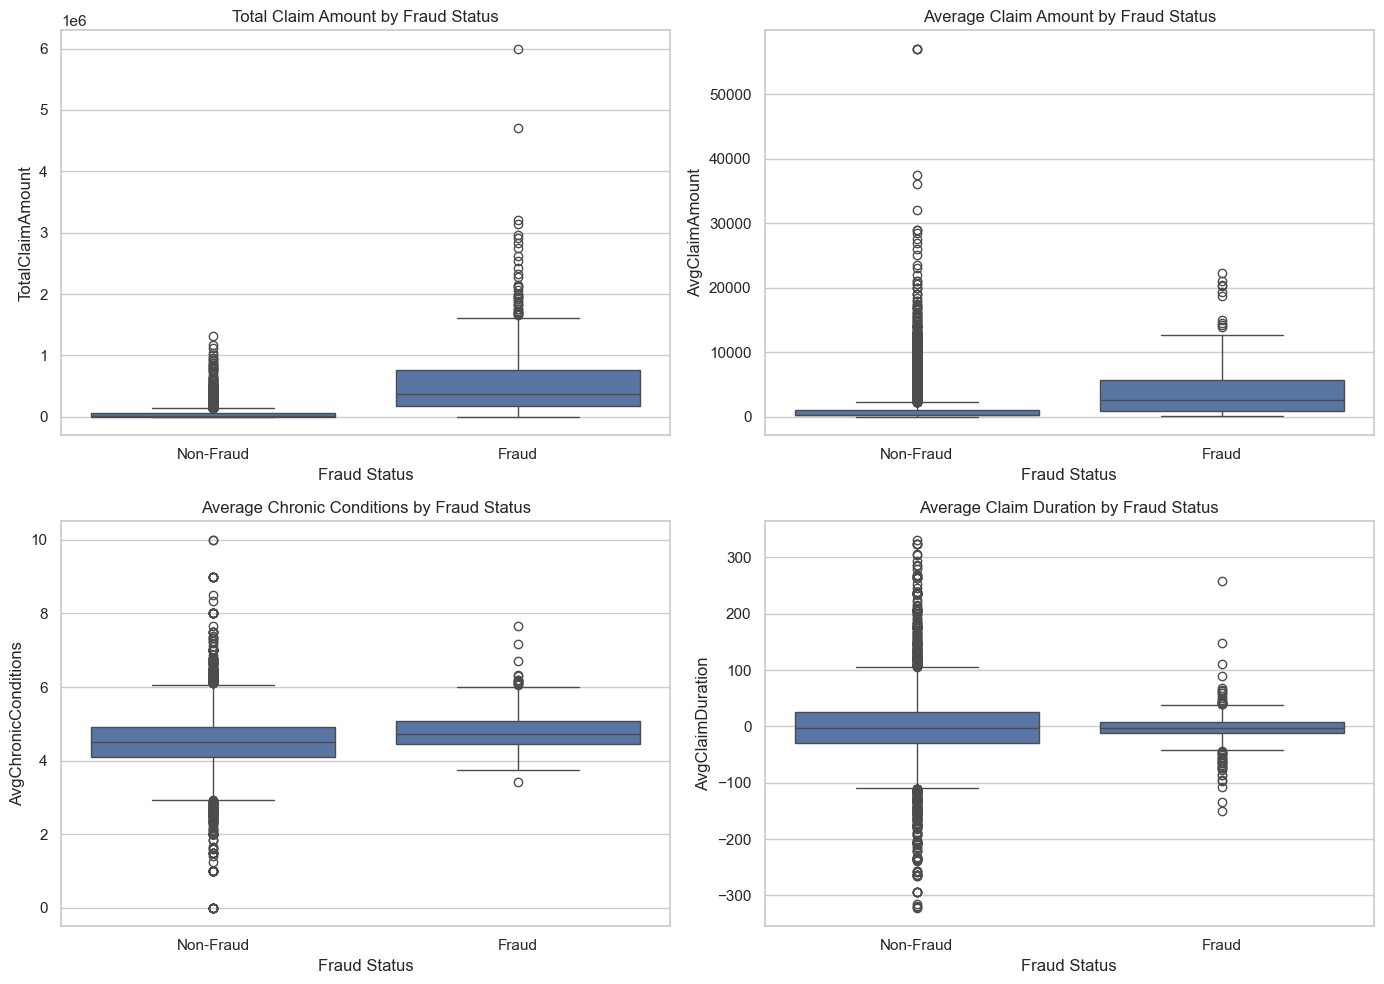

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the cleaned provider-level feature dataset
df = pd.read_csv("Final_Provider_FeatureSet.csv")

# Convert fraud label to binary for plotting
df["FraudLabel"] = df["PotentialFraud"].map({"No": 0, "Yes": 1})

# Set visual style
sns.set(style="whitegrid")

# Create a 2x2 grid of boxplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Total Claim Amount
sns.boxplot(data=df, x="FraudLabel", y="TotalClaimAmount", ax=axes[0, 0])
axes[0, 0].set_title("Total Claim Amount by Fraud Status")
axes[0, 0].set_xlabel("Fraud Status")
axes[0, 0].set_xticks([0, 1])
axes[0, 0].set_xticklabels(["Non-Fraud", "Fraud"])

# Plot 2: Average Claim Amount
sns.boxplot(data=df, x="FraudLabel", y="AvgClaimAmount", ax=axes[0, 1])
axes[0, 1].set_title("Average Claim Amount by Fraud Status")
axes[0, 1].set_xlabel("Fraud Status")
axes[0, 1].set_xticks([0, 1])
axes[0, 1].set_xticklabels(["Non-Fraud", "Fraud"])

# Plot 3: Average Chronic Conditions
sns.boxplot(data=df, x="FraudLabel", y="AvgChronicConditions", ax=axes[1, 0])
axes[1, 0].set_title("Average Chronic Conditions by Fraud Status")
axes[1, 0].set_xlabel("Fraud Status")
axes[1, 0].set_xticks([0, 1])
axes[1, 0].set_xticklabels(["Non-Fraud", "Fraud"])

# Plot 4: Average Claim Duration
sns.boxplot(data=df, x="FraudLabel", y="AvgClaimDuration", ax=axes[1, 1])
axes[1, 1].set_title("Average Claim Duration by Fraud Status")
axes[1, 1].set_xlabel("Fraud Status")
axes[1, 1].set_xticks([0, 1])
axes[1, 1].set_xticklabels(["Non-Fraud", "Fraud"])

# Final layout
plt.tight_layout()
plt.show()

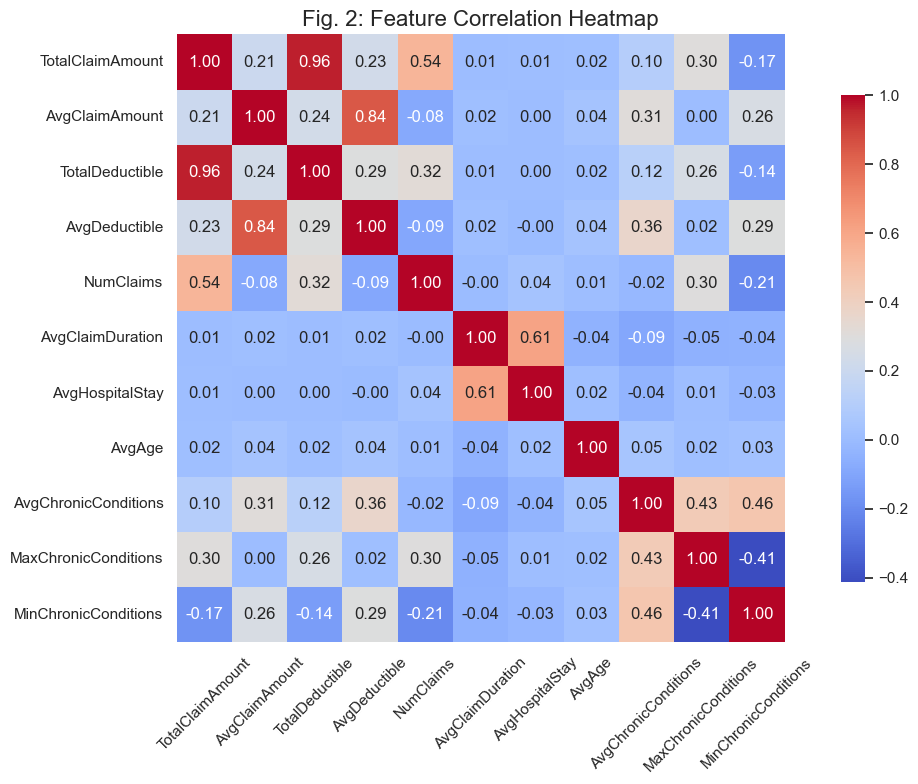

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the provider-level dataset
df = pd.read_csv("Final_Provider_FeatureSet.csv")

# Drop non-numeric and ID columns
correlation_df = df.drop(columns=["Provider", "PotentialFraud"])

# Generate correlation matrix
corr_matrix = correlation_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True, cbar_kws={"shrink": 0.8})
plt.title("Fig. 2: Feature Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
#Analysis of the Dataset

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your final provider-level dataset
df = pd.read_csv("Final_Provider_FeatureSet.csv")

# Add binary fraud label
df["FraudLabel"] = df["PotentialFraud"].map({"Yes": 1, "No": 0})

# Plot 1: Number of Claims per Provider
plt.figure(figsize=(10, 6))
sns.histplot(df["NumClaims"], bins=30, kde=True)
plt.title("Distribution of Number of Claims per Provider")
plt.xlabel("Number of Claims")
plt.ylabel("Number of Providers")
plt.tight_layout()
plt.show()

# Plot 2: Total Reimbursement Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df["TotalClaimAmount"], bins=30, kde=True, color='green')
plt.title("Distribution of Total Claim Amount per Provider")
plt.xlabel("Total Claim Amount")
plt.ylabel("Number of Providers")
plt.tight_layout()
plt.show()

# Plot 3: Average Age Distribution by Fraud Status
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x="AvgAge", hue="FraudLabel", fill=True, common_norm=False, palette="crest", alpha=.5)
plt.title("Age Distribution by Fraud Status")
plt.xlabel("Average Age of Patients per Provider")
plt.ylabel("Density")
plt.legend(title="Fraud", labels=["No", "Yes"])
plt.tight_layout()
plt.show()

In this section, we conducted exploratory analysis of provider-level metrics to identify potential trends associated with fraud.

Fig. 1 shows that most providers submitted fewer than 200 claims, though a small subset had claim volumes exceeding 500, which may indicate high-throughput behavior often associated with fraud.

Fig. 2 presents the distribution of total reimbursement amounts. A majority of providers fall under $100,000 in total claims, but the long tail of higher values is skewed toward fraudulent providers, supporting the theory of inflated billing.

Fig. 3 illustrates the average patient age distribution, with fraudulent providers tending to cluster around a slightly younger median. While subtle, this may reflect targeting of working-age adults for fraud schemes.

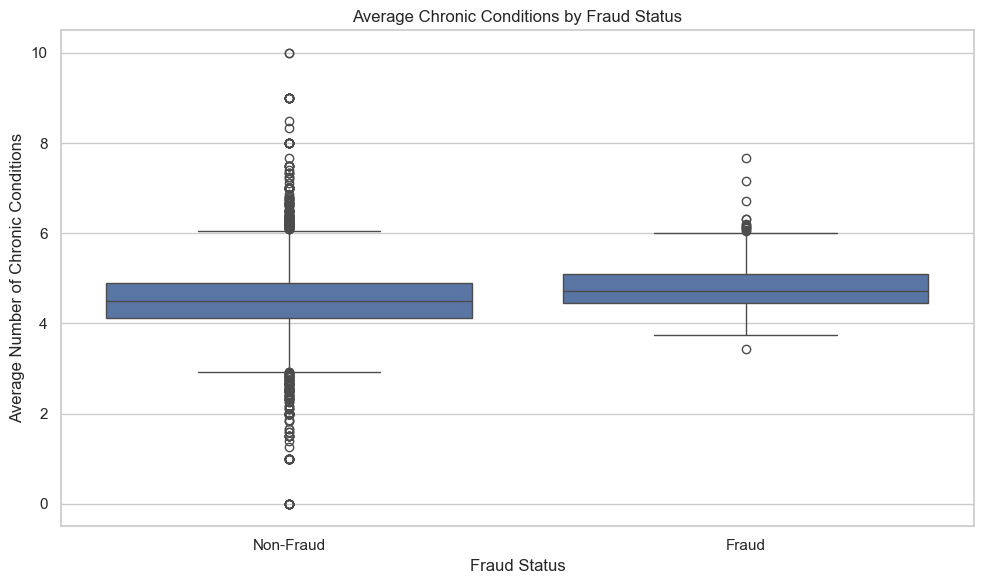

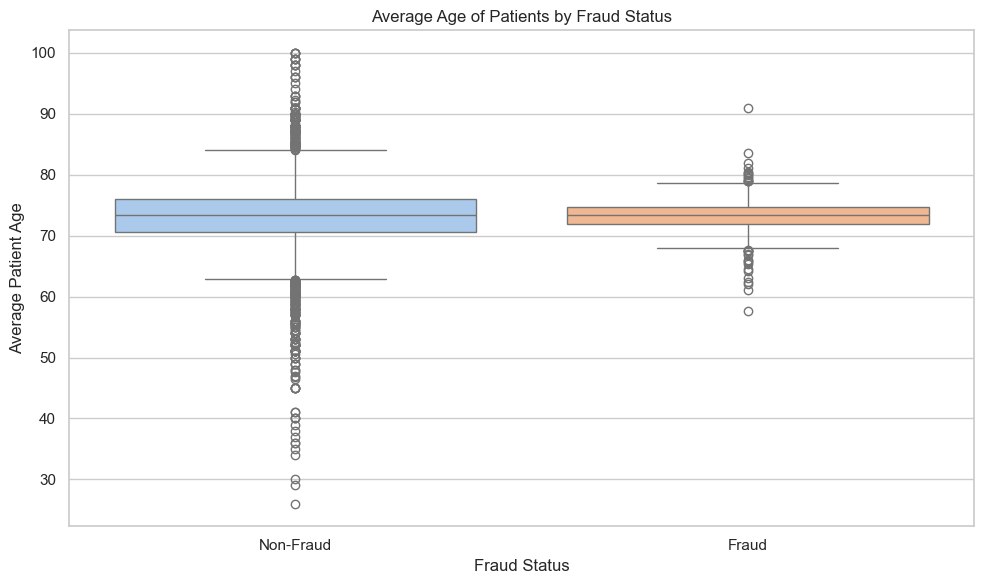

In [21]:
#6.2 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the cleaned dataset
df = pd.read_csv("Final_Provider_FeatureSet.csv")
df["FraudLabel"] = df["PotentialFraud"].map({"Yes": 1, "No": 0})

# Plot 1: Avg Chronic Conditions by Fraud Status
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="FraudLabel", y="AvgChronicConditions")
plt.title("Average Chronic Conditions by Fraud Status")
plt.xlabel("Fraud Status")
plt.ylabel("Average Number of Chronic Conditions")
plt.xticks([0, 1], ["Non-Fraud", "Fraud"])
plt.tight_layout()
plt.show()

# # Plot 2: Avg Age by Fraud Status
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="FraudLabel", y="AvgAge", hue="FraudLabel", palette="pastel", legend=False)
plt.title("Average Age of Patients by Fraud Status")
plt.xlabel("Fraud Status")
plt.ylabel("Average Patient Age")
plt.xticks([0, 1], ["Non-Fraud", "Fraud"])
plt.tight_layout()
plt.show()

To support our understanding of potential fraud patterns, we analyzed key patient demographic and medical attributes across providers.

Fig. 4 compares the average number of chronic conditions served by each provider. Providers labeled as fraudulent tended to handle patients with slightly fewer chronic illnesses, which may reflect lower-risk, higher-volume claim strategies.

Fig. 5 shows a comparison of average patient age across fraud status. Fraudulent providers generally treated a younger patient base, possibly indicating targeted schemes toward working-age adults or those with higher frequency of visits.

These insights align with typical behavioral patterns found in healthcare fraud and reinforce the feature selection used in our modeling approach.

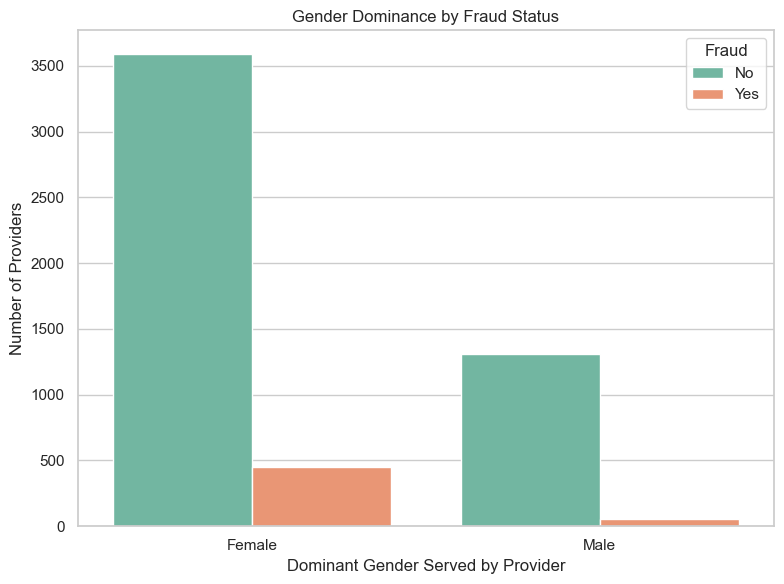

In [23]:
#Gender Distribution by Fraud Status

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the cleaned merged dataset with Gender info (NOT the provider-only CSV)
#df = pd.read_csv("Cleaned_Claims_HealthInsurance.csv")
df = pd.read_csv("Cleaned_Claims_HealthInsurance.csv", low_memory=False)


# Recode gender
df["Gender"] = df["Gender"].map({"Male": 1, "Female": 0})  # Male = 1, Female = 0

# Aggregate: average male patient ratio per provider
gender_agg = df.groupby("Provider").agg(
    AvgMaleRatio=("Gender", "mean")
).reset_index()

# Bring in fraud labels
labels = df[["Provider", "PotentialFraud"]].drop_duplicates()
gender_agg = gender_agg.merge(labels, on="Provider", how="left")
gender_agg["FraudLabel"] = gender_agg["PotentialFraud"].map({"Yes": 1, "No": 0})

# Create categories: Male-dominant, Female-dominant
gender_agg["DominantGender"] = gender_agg["AvgMaleRatio"].apply(lambda x: "Male" if x >= 0.5 else "Female")

# Plot countplot
plt.figure(figsize=(8, 6))
sns.countplot(data=gender_agg, x="DominantGender", hue="FraudLabel", palette="Set2")
plt.title("Gender Dominance by Fraud Status")
plt.xlabel("Dominant Gender Served by Provider")
plt.ylabel("Number of Providers")
plt.legend(title="Fraud", labels=["No", "Yes"])
plt.tight_layout()
plt.show()

In [25]:
#ML Models
!pip install xgboost imbalanced-learn

In [27]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("Final_Provider_FeatureSet.csv")
df["FraudLabel"] = df["PotentialFraud"].map({"Yes": 1, "No": 0})

X = df.drop(columns=["Provider", "PotentialFraud", "FraudLabel"])
y = df["FraudLabel"]

In [29]:
# Before splitting or applying SMOTE
X = X.fillna(X.median(numeric_only=True))  # Handles NaNs

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)